# Indiana Groundwater Chemistry

All of Indiana is above the Wabash basin, a subbasin of the Missippi river. This notebook looks at a historical groundwater chemistry dataset. Published by the Indiana DNR.

In [104]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import utm
import shapefile
import geopandas as gpd
import numpy as np
from scipy.interpolate import NearestNDInterpolator 

In [105]:
#import data

#set the filepath
gw_filepath = r"C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\IDNR_GWchem\Data\GWCHEM_AA.xls"

# read in the data file
# dates are listed in seperate columns: 30, 31, 32 for month, day, year
IDNR_gw_full = pd.read_excel(gw_filepath, 
                             sheet_name = "basins", 
                             header = 6, 
                             skiprows = 6,
                             #index_col='date', 
                             parse_dates={'date': [32,30,31]})

# show the top of the dataset
IDNR_gw_full.head()

,date,ref.no,pub.no,samp.no,UTMN,UTME,COUNTY,TOWNSHIP,RANGE,SECTION,...,LEAD,ARS,SEL,BOR,COMMENTS.1,Well type,Ref No.,Unnamed: 59,Sample #,Basin
0,1989-07-19,85,NaN,WF-024,4451775,623650,18,20,9,6,...,NaN,NaN,NaN,NaN,NaN,B,85,NaN,WF-024,WF
1,1989-07-11,1302,NaN,WF-002,4450598,632343,18,20,10,7,...,NaN,NaN,NaN,NaN,NaN,U,1302,NaN,WF-002,WF
2,1989-07-11,1551,NaN,WF-003,4447960,637860,18,20,10,22,...,NaN,NaN,NaN,NaN,NaN,U,1551,NaN,WF-003,WF
3,1989-07-13,2577,NaN,WF-014,4456595,627750,18,21,9,22,...,NaN,NaN,NaN,NaN,NaN,B,2577,NaN,WF-014,WF
4,1989-07-13,2752,NaN,WF-011A,4459750,641860,18,21,10,12,...,NaN,NaN,NaN,NaN,NaN,B,2752,NaN,WF-011A,WF


In [106]:
#convert UTM coordinates to lat lon
IDNR_gw_full['lat'], IDNR_gw_full['lon'] = utm.to_latlon(IDNR_gw_full['UTME'], IDNR_gw_full['UTMN'], 16, northern=True)
IDNR_gw_full.head()

,date,ref.no,pub.no,samp.no,UTMN,UTME,COUNTY,TOWNSHIP,RANGE,SECTION,...,SEL,BOR,COMMENTS.1,Well type,Ref No.,Unnamed: 59,Sample #,Basin,lat,lon
0,1989-07-19,85,NaN,WF-024,4451775,623650,18,20,9,6,...,NaN,NaN,NaN,B,85,NaN,WF-024,WF,40.207272,-85.547048
1,1989-07-11,1302,NaN,WF-002,4450598,632343,18,20,10,7,...,NaN,NaN,NaN,U,1302,NaN,WF-002,WF,40.195345,-85.445177
2,1989-07-11,1551,NaN,WF-003,4447960,637860,18,20,10,22,...,NaN,NaN,NaN,U,1551,NaN,WF-003,WF,40.170698,-85.380950
3,1989-07-13,2577,NaN,WF-014,4456595,627750,18,21,9,22,...,NaN,NaN,NaN,B,2577,NaN,WF-014,WF,40.250068,-85.497927
4,1989-07-13,2752,NaN,WF-011A,4459750,641860,18,21,10,12,...,NaN,NaN,NaN,B,2752,NaN,WF-011A,WF,40.276208,-85.331388


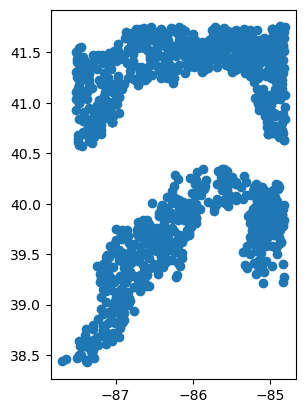

In [107]:
#convert pandas df into geodf
idnr_gdf = gpd.GeoDataFrame(IDNR_gw_full, 
                           geometry= gpd.points_from_xy(IDNR_gw_full['lon'], IDNR_gw_full['lat']),
                            #could also use gpd.points_from_xy(usgs_pd.longitude, ...
                           crs = "EPSG:4326") #shorthand for lat lon

idnr_gdf.head()
idnr_gdf.plot();


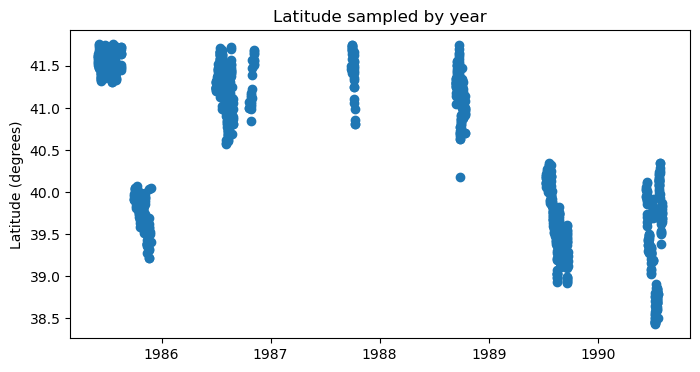

In [108]:
#display data entries over time

""" Create dates and plot the data. """
#gw_dates = pd.date_range(start='1985-01-01', end='1991-12-31', freq='d')

#plot the data over time
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(IDNR_gw_full['date'], IDNR_gw_full['lat'])
ax.set_title("Latitude sampled by year")
ax.set_ylabel("Latitude (degrees)")
plt.show()

Interesting spread of data over time... There's a suspicious lack of data in the middle latitudes. Let's see what the data looks like on a map.

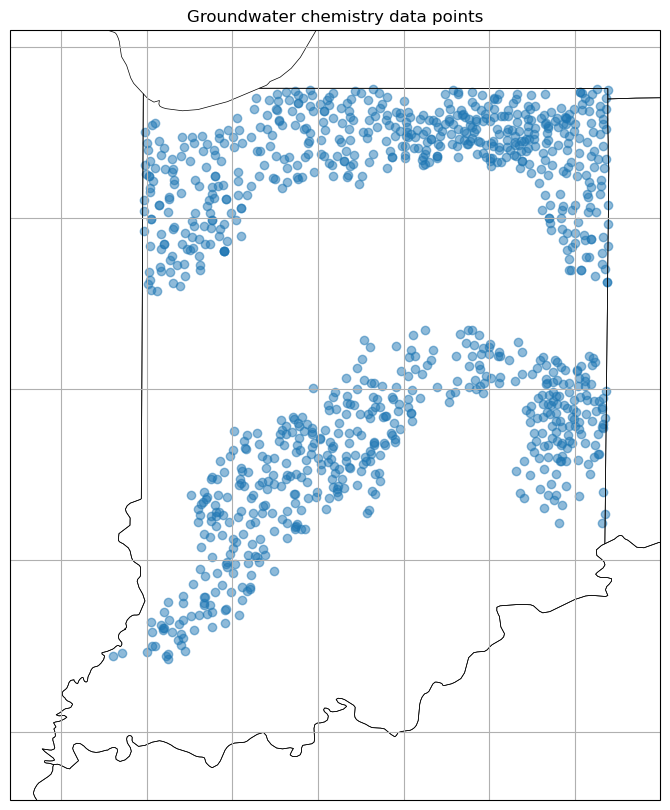

In [109]:
"""Plot data points on the map"""
projection = cartopy.crs.PlateCarree()

# create the plot
fig, ax = plt.subplots(
    figsize = (10,10),
    subplot_kw= {"projection": projection}) # or =dict(projection = projection) ?

#convert projection into PORJ4 string
ax_proj = ax.projection.proj4_init

#convert the usgs data to the projection
idnr_gdf_proj = idnr_gdf.to_crs(ax_proj)
idnr_gdf_proj.plot(ax = ax, 
                   transform = projection,
                   #column = "mag", # generates points colored by magnitude
                   #markersize = np.exp(idnr_gdf_proj.mag)/10,
                   alpha = 0.5 #transparancy
                   ) 

#add gridlines
ax.gridlines()
#add states outline
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)

# want to see whole state
# Set map extent
ax.set_extent([-88.3, -84.5, 37.6, 42.1], crs=cartopy.crs.PlateCarree())

ax.set_title("Groundwater chemistry data points");

The coverage here is not great, and not what I expected. But let's see how it aligns with the Wabash Basin.

Wabash HUC12 Subbasin Shapefile credits:
Dierauer, J.R. (2019). Wabash River Basin USGS NHD HUC 12 polygon shapefile. figshare. Dataset. https://doi.org/10.6084/m9.figshare.8398394.v7

In [110]:
# provide path of shapefile
shp_path = r'C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\data\WBHUC12shp\Wabash_HUC12.shp'

HUC_shp = shapefile.Reader(shp_path)

#print what shapetype the shapefile is. 5 means polygon
print(HUC_shp.shapeType)

#how many features are there?
len(HUC_shp)


5


1276

Our shapefile is set of 1276 polygons. A review of the file "WabashSubbasins_IDtoHUC.csv" (in data\WBHUC12shp) tells us there is indeed 1276 HUC12 subbasins in the basin, so we're likely looking at the right thing.

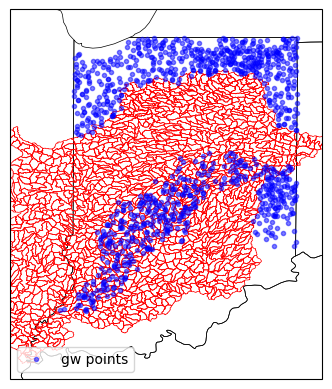

In [111]:
#import more specific functions
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

#create the plot
fig, ax = plt.subplots( subplot_kw= dict(projection = projection))
ax.plot(IDNR_gw_full['lon'], IDNR_gw_full['lat'], '.', color="b", alpha = 0.5,  transform = projection, label = "gw points")
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
# Set map extent
ax.set_extent([-88.3, -84.5, 37.6, 42.1], crs=cartopy.crs.PlateCarree())



# add shapefile as feature
state_feature = ShapelyFeature(Reader(shp_path).geometries(),
                               crs=cartopy.crs.PlateCarree(), facecolor="none", edgecolor='r', linewidth=0.5)
ax.add_feature(state_feature)
ax.legend()



plt.show() 

This isn't pretty, but there's enough overlap for us to do an analysis with the overlapping sections.


It's interesting to see the groundwater sample points conform to the outline of the Wabash basin in parts, such as along the north border or part of the east. I wonder what's there that we can't see from this map.

### about the shapefile

A key for what basin # coordinates to the subbasin name is provided in the file:
- research_project\data\WBHUC12shp\WabashSubbasins_IDtoHUC.csv





In [112]:
# convert to geodataframe
HUC_gdf_org = gpd.read_file(shp_path)
HUC_gdf_org.head()

,GRIDCODE,Subbasin,Area_ha,geometry
0,1,1,4318.721679,"POLYGON ((-87.92583 39.88529, -87.92729 39.882..."
1,2,2,6839.489349,"POLYGON ((-87.69378 39.12514, -87.69561 39.121..."
2,3,3,7003.366250,"POLYGON ((-87.58176 38.98668, -87.58353 38.985..."
3,4,4,11780.955140,"POLYGON ((-87.69344 39.06905, -87.69206 39.067..."
4,5,5,6969.422343,"POLYGON ((-88.19354 40.09454, -88.18975 40.092..."


If we can separate points by what subbasin they're in, we can analyze points by subbasin and compare them to the FutureWater data and RCP scenarios.

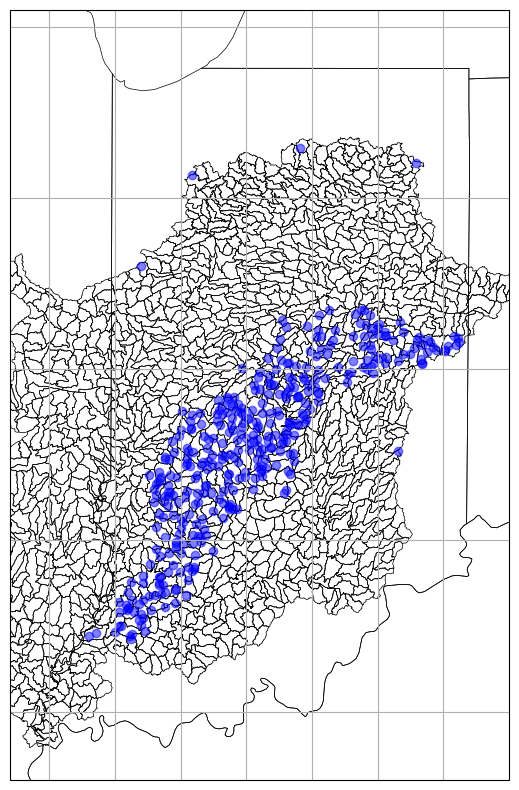

In [113]:
"""clip the datasets"""

# convert HUC boundary to projection of  dataset
HUC_gdf = HUC_gdf_org.to_crs(idnr_gdf.crs)

# clip the earthwuakes to the CA boundary
idnr_gdf_clipped = gpd.clip(idnr_gdf, HUC_gdf) #inputs are (dataset to clip, boundary to clip to)


# plot clipped eqs
fig, ax = plt.subplots(
    figsize = (10,10),
    subplot_kw= {"projection": projection}) #does the interior differentiate to cartopy plot, not simple?

# plot HUC 12 boundaries
HUC_gdf.plot(ax=ax, 
             facecolor="none", 
             edgecolor="black",
             linewidth=0.5
             ) #facecolor colors interior of polygon!

# convert the usgs data to the projection
idnr_gdf_clipped.plot(
                    ax = ax, 
                   #transform = projection, #remember to take this out
                   #column = "mag", #if just this, generates points colored by magnitude
                   #markersize = np.exp(name.variable)/10,
                   color="b",
                   alpha = 0.5 #transparancy
                   ) 
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
ax.set_extent([-88.3, -84.5, 37.6, 42.1], crs=cartopy.crs.PlateCarree())
ax.gridlines()
plt.show()


In [114]:
idnr_gdf_clipped

,date,ref.no,pub.no,samp.no,UTMN,UTME,COUNTY,TOWNSHIP,RANGE,SECTION,...,BOR,COMMENTS.1,Well type,Ref No.,Unnamed: 59,Sample #,Basin,lat,lon,geometry
369,1990-07-10,82044,NaN,WF-280,4253175,467260,63,1,9,14,...,NaN,NaN,B,82044,NaN,WF-280,WF,38.426235,-87.375085,POINT (-87.37509 38.42623)
370,1990-07-10,82045,NaN,WF-279,4254775,466140,63,1S,9,11,...,NaN,NaN,B,82045,NaN,WF-279,WF,38.440612,-87.387993,POINT (-87.38799 38.44061)
366,1990-07-09,82041,NaN,WF-274A,4255100,439185,42,1S,12,12,...,NaN,NaN,B,82041,NaN,WF-274A,WF,38.442111,-87.696875,POINT (-87.69688 38.44211)
368,1990-07-10,82043,NaN,WF-281,4256130,467375,63,1,9,2,...,NaN,NaN,B,82043,NaN,WF-281,WF,38.452870,-87.373905,POINT (-87.37390 38.45287)
367,1990-07-09,82042,NaN,WF-275,4256850,443850,42,1S,11,4,...,NaN,NaN,U,82042,NaN,WF-275,WF,38.458188,-87.643563,POINT (-87.64356 38.45819)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,1990-07-24,82196,NaN,WF-334A,4445400,656240,68,20,12,34,...,NaN,NaN,U,82196,NaN,WF-334A,WF,40.144427,-85.165811,POINT (-85.16581 40.14443)
520,1990-07-24,82198,NaN,WF-333,4448210,660355,68,20,13,19,...,NaN,NaN,B,82198,NaN,WF-333,WF,40.168955,-85.116828,POINT (-85.11683 40.16895)
644,1989-07-12,86542,NaN,WF-007,4448070,652890,68,20,12,20,...,NaN,NaN,U,86542,NaN,WF-007,WF,40.169087,-85.204487,POINT (-85.20449 40.16909)
645,1989-07-12,86547,NaN,WF-006,4450575,654370,68,20,12,9,...,NaN,NaN,B,86547,NaN,WF-006,WF,40.191373,-85.186514,POINT (-85.18651 40.19137)


The clip shows us that if we limit the dataset to points within the Wabash basin, it leaves us 379 points to work with. If only there was a way to get rid of the 5 outlier-looking ones. That would strengthen an interpolation map.

A spatial join would match all points with polygons. I can't believe I didn't think to do this before. Let's try it.

In [115]:
#spatial join polygons to points
idnr_HUC = gpd.sjoin(idnr_gdf, HUC_gdf) #Join
idnr_HUC


,date,ref.no,pub.no,samp.no,UTMN,UTME,COUNTY,TOWNSHIP,RANGE,SECTION,...,Unnamed: 59,Sample #,Basin,lat,lon,geometry,index_right,GRIDCODE,Subbasin,Area_ha
0,1989-07-19,85,NaN,WF-024,4451775,623650,18,20,9,6,...,NaN,WF-024,WF,40.207272,-85.547048,POINT (-85.54705 40.20727),318,319,319,5754.626389
608,1989-07-19,85877,NaN,WF-025,4450050,619030,48,20,8,10,...,NaN,WF-025,WF,40.192404,-85.601639,POINT (-85.60164 40.19240),318,319,319,5754.626389
1,1989-07-11,1302,NaN,WF-002,4450598,632343,18,20,10,7,...,NaN,WF-002,WF,40.195345,-85.445177,POINT (-85.44518 40.19534),315,316,316,6738.546593
6,1989-07-10,3082,NaN,WF-001,4453030,632530,18,21,10,31,...,NaN,WF-001,WF,40.217218,-85.442480,POINT (-85.44248 40.21722),315,316,316,6738.546593
516,1990-07-23,82194,NaN,WF-326,4451980,627840,18,20,9,3,...,NaN,WF-326,WF,40.208490,-85.497788,POINT (-85.49779 40.20849),315,316,316,6738.546593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,1990-07-25,142321,NaN,WF-341,4443875,617910,48,20,8,33,...,NaN,WF-341,WF,40.136944,-85.615923,POINT (-85.61592 40.13694),356,357,357,4770.778404
894,1989-07-24,144989,NaN,WF-036,4447400,598700,48,20,6,22,...,NaN,WF-036,WF,40.171172,-85.840830,POINT (-85.84083 40.17117),361,362,362,5843.162150
971,1985-11-25,196620,113,WW-113,4376200,642220,70,12,11,6,...,NaN,WW-113,WW,39.523683,-85.345358,POINT (-85.34536 39.52368),698,699,699,5246.725439
988,1990-06-27,215241,NaN,WF-251,4347865,520025,60,10,3,29,...,NaN,WF-251,WF,39.279911,-86.767825,POINT (-86.76782 39.27991),738,739,739,4440.530256


This is great. We have only our overlapping 400 or so points, which also have the attributes of the polygon they can be found in. We can use this to match these points to the FutureWater data later. 

Let's interpolate some of the geochemical parameters presented in these points. I'll be using hardness as a general proxy for concentration of ions in groundwater, and thus how 'affected' is has been by flowing through the ground, picking up dissolved ions. 

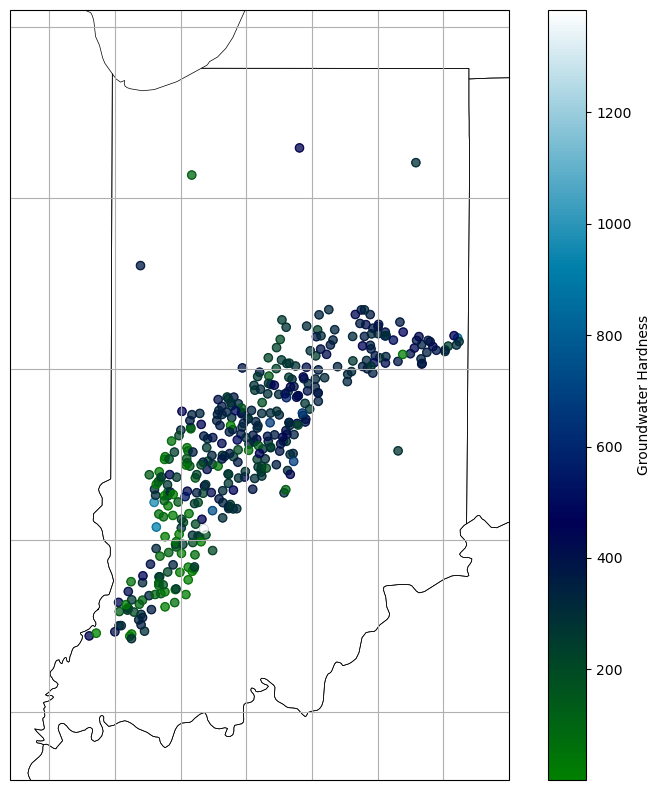

In [116]:
"""interpolate hardness"""

# create the plot
fig, ax = plt.subplots(
    figsize = (10,10),
    subplot_kw= {"projection": projection}) 


idnr_HUC.plot(ax=ax, 
             #column = "geometry",
             facecolor="none", 
             edgecolor="black",
             linewidth=0.5
             ) #facecolor colors interior of polygon!

#convert the usgs data to the projection
idnr_HUC.plot(ax = ax, 
                column = "HARDNESS", #if just this, generates points colored by variable
                #markersize = (idnr_HUC.IRON), #np.exp()/10,
                #color="b",
                alpha = 0.75, #transparancy
                cmap = "ocean",
                legend = True,
                legend_kwds=dict(label="Groundwater Hardness",pad=0.05), #additional: orientation="horizontal"
                ) 
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)
ax.set_extent([-88.3, -84.5, 37.6, 42.1], crs=cartopy.crs.PlateCarree())
ax.gridlines()
plt.show();

In [118]:
"""convert lat lon to easting/northing to make interpolation accurate"""

# convert projection
#idnr_HUC = (gpd.GeoDataFrame(idnr_HUC, crs="EPSG:4326", geometry=gpd.points_from_xy(idnr_HUC["lon"], idnr_HUC["lat"]))
#            .to_crs("EPSG:3347")
#        )

# create new columns 
#idnr_HUC["Easting"], idnr_HUC["Northing"] = (idnr_HUC.geometry.x), (idnr_HUC.geometry.y)
#idnr_HUC.head()

'convert lat lon to easting/northing to make interpolation accurate'

I couldn't figure out how to change the projection once the interpolation had been created, so I 

C:\Users\janel\AppData\Local\Temp\ipykernel_17540\348175896.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, y, "ok", color = "orange", alpha = 0.25, label="groundwater point")


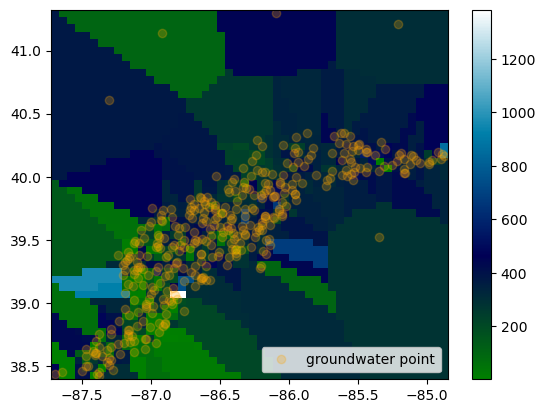

In [203]:
""" Spatial interpolation using nearest neighbors """

# set dimensions
#x = idnr_HUC.Northing
#y = idnr_HUC.Easting
x = idnr_HUC.lon
y = idnr_HUC.lat
z = idnr_HUC.HARDNESS

# create 2D grid for interpolation
X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  

# interpolate variable
interp = NearestNDInterpolator(list(zip(x, y)), z)

Z = interp(X, Y)

# plot the interpolation
plt.pcolormesh(X, Y, Z, cmap = 'ocean', shading='auto')
plt.plot(x, y, "ok", color = "orange", alpha = 0.25, label="groundwater point")
plt.legend()
plt.colorbar()
plt.show()



C:\Users\janel\AppData\Local\Temp\ipykernel_17540\2228123698.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, y, "ok", color = "black", markersize = 1.5, alpha = 0.5, label="Groundwater sample points")


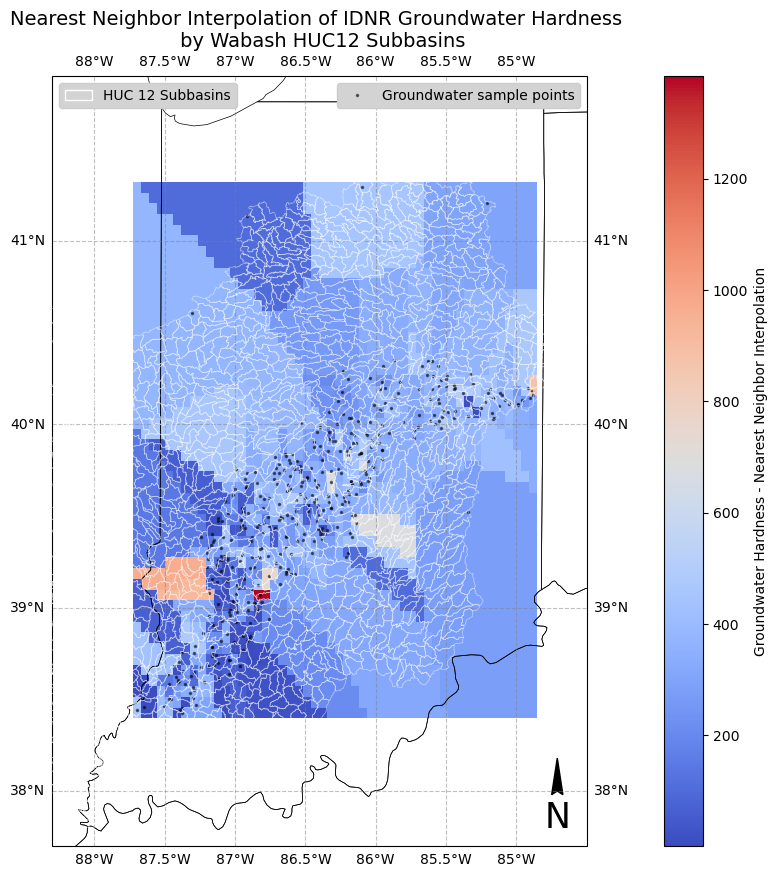

In [204]:
""" Plot with all data"""

# create the plot
fig, ax = plt.subplots(
    figsize = (10,10),
    subplot_kw= {"projection": projection}) 

cmap = "coolwarm"
#Z.plot(ax=ax, 
             #column = "geometry",
             #facecolor="none", 
             #edgecolor="black",
             #linewidth=0.5)
             #facecolor colors interior of polygon!
plt.pcolormesh(X, Y, Z, cmap = cmap, shading='auto') 


# convert projection / projection is already "EPSG:3347"
#idnr_HUC = (gpd.GeoDataFrame(idnr_HUC, crs="EPSG:3347", geometry=gpd.points_from_xy(idnr_HUC["Easting"], idnr_HUC["Northing"])))

# plot HUC 12 boundaries
HUC_gdf.plot(ax=ax, 
             facecolor="none", 
             edgecolor="white",
             alpha = 0.5,
             linewidth=0.5,
             zorder = 10,
             ) #facecolor colors interior of polygon!

# plot points so colorbar shows
idnr_HUC.plot(ax = ax, 
                column = "HARDNESS", #if just this, generates points colored by variable
                markersize = 0.1,
                #color="b",
                alpha = 1, #transparancy
                cmap = cmap,
                legend = True,
                legend_kwds=dict(label="Groundwater Hardness - Nearest Neighbor Interpolation",pad=0.1), #additional: orientation="horizontal"
                ) 

# add sample points
plt.plot(x, y, "ok", color = "black", markersize = 1.5, alpha = 0.5, label="Groundwater sample points")

# add state boundaries
ax.add_feature(cartopy.feature.STATES, linewidth=0.5)

# set extent
ax.set_extent([-88.3, -84.5, 37.7, 41.9], crs=cartopy.crs.PlateCarree())
gl = ax.gridlines(draw_labels=True, color="gray", alpha=0.5, linestyle="--")
ax.set_title("Nearest Neighbor Interpolation of IDNR Groundwater Hardness \n by Wabash HUC12 Subbasins", size = 14)


# plot north arrow
ax.text(x=-84.8, y=37.8, s='N', fontsize=25)
ax.arrow(-84.71, 38, 0, 0.18, length_includes_head=True,
          head_width=0.08, head_length=0.2, overhang=.1, facecolor='k')

# add huc 12 boundaries to legend
# make a dummy object that looks similar
import matplotlib.patches as mpatches
proxy_artist = mpatches.Rectangle((0, 0), 1, 0.1, linewidth=1, edgecolor='white', facecolor='none', label = "HUC 12 Subbasins")
# manually add the label
legend1 = ax.legend(handles=[proxy_artist], facecolor='lightgray', framealpha=1, loc='upper left', fancybox=True)
ax.add_artist(legend1)

# add the original legend
ax.legend(facecolor='lightgray', framealpha=1, loc='best', fancybox=True)

# show plot
plt.show();

In [121]:
#pull out list of subbasins used
#we can use this for constricting data
overlappingbasins = [379, 0] #create new slice???
overlappingbasins = idnr_HUC[-2]


KeyError: -2

### Groundwater recharge in carbon emission scenarios

In [ ]:
#import data

#set the filepath
csvFWI_rech_hist = r"C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\data\FWI_historical_recharge.csv"
csvFWI_rech_2050_45 = r'C:\Users\janel\OneDrive\Documents\IU grad\Classes F23\EAS 690 Advanced Data Science\G690_Test\research_project\data\FWI_recharge_2050_RCP4.5.csv'

# read in the data file
# dates are listed in seperate columns: 30, 31, 32 for month, day, year
IDNR_gw_full = pd.read_csv(csvFWI_rech_hist, 
                             header = 0, 
                             skiprows = 0,
                             )

# show the top of the dataset
IDNR_gw_full.head()